## Kernel K means

### Advantages:

1) Algorithm is able to identify the non-linear structures.

2) Algorithm is best suited for real life data set.

### Disadvantages

1) Number of cluster centers need to be predefined.

2) Time complexity is large.

### Implementation in Spectral clustering
One version of this kernelized k-means is implemented in Scikit-Learn within the SpectralClustering estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm:

/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


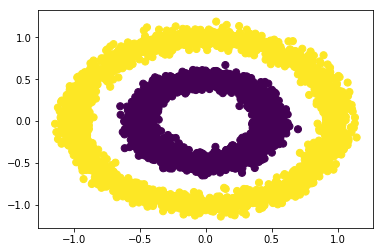

In [120]:
from sklearn.cluster import SpectralClustering
from sklearn import datasets
import matplotlib.pyplot as plt
### introduce large number of samples, so would take few seconds to run
X_test, y_test = datasets.make_circles(n_samples=5000, factor=.5,
                                  noise=.06)
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans', random_state = 0)
labels = model.fit_predict(X_test)

plt.scatter(X_test[:, 0], X_test[:, 1], c=labels,
            s=50, cmap='viridis');
plt.show()

### k-means can be slow for large numbers of samples
Because each iteration of k-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows. You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step. This is the idea behind batch-based k-means algorithms, one form of which is implemented in `sklearn.cluster.MiniBatchKMeans`. The interface for this is the same as for standard KMeans; we will see an example of its use as we continue our discussion.

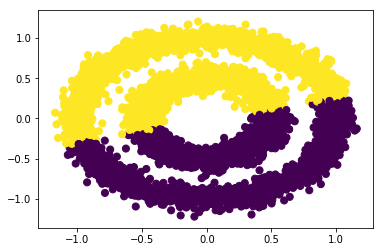

In [71]:
from sklearn.cluster import SpectralClustering,MiniBatchKMeans
### introduce large number of samples
### but of course cannot recognise non linearly separable structure
### but what if we want to use the kernel K means, can we use mini batch for that?
X_test, y_test = datasets.make_circles(n_samples=5000, factor=.5,
                                  noise=.07)
model = MiniBatchKMeans(n_clusters=2)
labels = model.fit_predict(X_test)

plt.scatter(X_test[:, 0], X_test[:, 1], c=labels,
            s=50, cmap='viridis');

So classic K-means are not able to detect the structure, see workaround in `kMeansAgglomerativeClustering.ipynb`


### K-means on digits

Here we will attempt to use k-means to try to identify similar digits without using the original label information; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any a priori label information.

We will start by loading the digits and then finding the KMeans clusters. Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

In [121]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape
data = digits.data

In [122]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(data)
kmeans.cluster_centers_.shape

(10, 64)

In [123]:
clusters

array([5, 9, 9, ..., 9, 4, 4], dtype=int32)

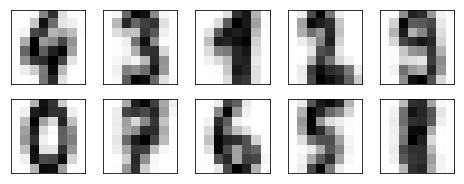

In [124]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that even without the labels, KMeans is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because k-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them:

In [125]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [126]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

~80 percent accuracy score for discovering digits and ~62 after scaling!

## Kernel k-means

In [127]:
from sklearn.preprocessing import StandardScaler

model = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', eigen_solver='arpack',
                           assign_labels='kmeans', n_init = 10)
# runs too slow, even with 'amg'
#model = SpectralClustering(n_clusters=10, affinity='rbf', eigen_solver='amg',
#                           assign_labels='kmeans', n_init = 10, gamma = 1)

clusters = model.fit_predict(data)


In [128]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [129]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.8230383973288815

In [90]:
# run before fitting ot check how would the model perform with scaling
scaler = StandardScaler()
scaler.fit(digits.data)
data = scaler.transform(digits.data)

- ~82 percent accuracy score for discovering digits on *unscaled* data!
- ~80% on scaled data - performs worse on *scaled* data!

### Takeout: 
scaling makes k-means to perform worse, the right choice would be dimensionality reduction technigue and then using, for instance t-SNE

In [96]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)


In [101]:
# Compute the clusters with classical k-means
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
from sklearn.metrics import accuracy_score
# Compute the accuracy
accuracy_score(digits.target, labels)

0.9371174179187535

In [117]:
# Compute the clusters with spectral clustering
kmeans = SpectralClustering(n_clusters=10, affinity='nearest_neighbors',
                           assign_labels='kmeans', random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
from sklearn.metrics import accuracy_score
# Compute the accuracy
accuracy_score(digits.target, labels)

# with spectral clustering after t-SNE the accuracy is low, kernel k means should use other combinations/params:

/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


0.5091819699499165

### References:

- https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
    